In [0]:
# This code is based on the Reinforcement Learning textbook by Richard Sutton and Andrew Barto
# Link to the textbook: http://incompleteideas.net/book/RLbook2018.pdf
# The dependencies for this code are numpy, openai's gym and python 3.6+

In [0]:
import gym
env = gym.make('Blackjack-v0')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def color_plot(arr, x_bot=None, x_top=None, y_bot=None, y_top=None):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.imshow(arr)
  ax.set_aspect('equal')
  plt.colorbar(orientation='vertical')
  if x_bot and x_top:
    plt.xlim(x_bot, x_top)
  if y_bot and y_top:
    plt.ylim(y_bot, y_top)

  plt.show()

## First Visit MC
For the purpose of policy evaluation

In [0]:
# Policy that only sticks if the sum is 20 or 21
policy = np.ones((32, 11, 2))
policy[20:22, :, :] = 0
policy[9:11, :, 1] = 0

V_s = np.zeros((32, 11, 2))
ret = np.zeros((32, 11, 2))
count = np.zeros((32, 11, 2))

DISCOUNT = 1

In [0]:
for _ in range(500000):
  hand, show, ace = env.reset()
  
  done = False
  g = 0
  episode = []
  
#   Do the episode following the policy
  while not done:
    state = (hand, show, int(ace))
    (hand, show, ace), reward, done, _ = env.step(int(policy[state]))
    
    episode.append((state, reward))
  
  while len(episode) > 0:
    state, reward = episode.pop()
    g = DISCOUNT * g + reward
    if (state, reward) not in episode:
      count[state] += 1
      V_s[state] += (g - V_s[state])/count[state]


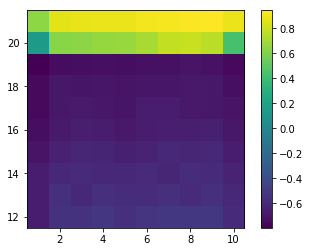

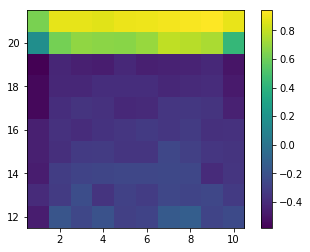

In [6]:
color_plot(V_s[:,:,0], 0.5, 10.5, 11.5, 21.5)
color_plot(V_s[:,:,1], 0.5, 10.5, 11.5, 21.5)

## Monte Carlo Exploring Starts
For the purpose of policy improvement

In [0]:
usable = np.zeros((32, 11, 2, 2))
usable[1:22, 1:12] = 1
q = np.random.random((32, 11, 2, 2)) * usable
policy = np.argmax(q, axis=3)
ret = np.zeros((32, 11, 2, 2))
count = np.zeros((32, 11, 2, 2))

In [0]:
DISCOUNT = 1

for _ in range(1000000):
  hand, show, ace = env.reset()
  state = (hand, show, int(ace))

  done = False
  g = 0
  episode = []
  action = np.random.randint(0, 2)
  (hand, show, ace), reward, done, _ = env.step(action)
  
  episode.append((state, action, reward))
  
#   Do the rest of the episode following the policy
  while not done:
    state = (hand, show, int(ace))
    action = int(policy[state])
    (hand, show, ace), reward, done, _ = env.step(action)
    
    episode.append((state, action, reward))
  
  while len(episode) > 0:
    state, action, reward = episode.pop()
    g = DISCOUNT * g + reward
    
    if (state, action, reward) not in episode:
      count[state + tuple([action])] += 1
      q[state + tuple([action])] += (g - q[state + tuple([action])])/count[state + tuple([action])]
      policy[state] = np.argmax(q[state])


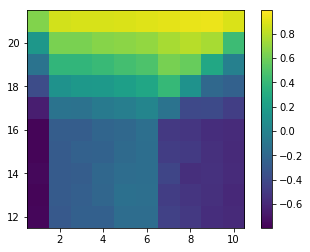

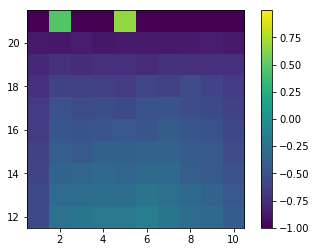

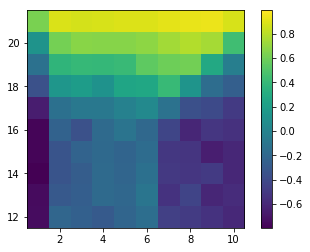

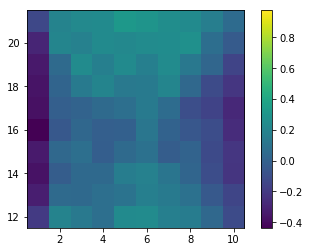

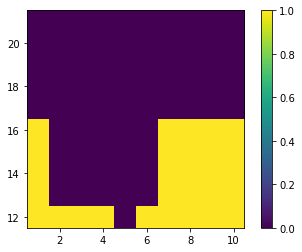

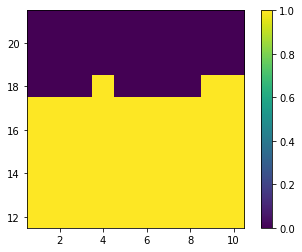

In [9]:
for i in range(2):
  for j in range(2):
    color_plot(q[:,:,i,j], 0.5, 10.5, 11.5, 21.5)
color_plot(policy[:,:,0], 0.5, 10.5, 11.5, 21.5)
color_plot(policy[:,:,1], 0.5, 10.5, 11.5, 21.5)

## On-Policy First-Visit Monte Carlo
$\epsilon$ soft policies

In [0]:
epsilon = 0.1

usable = np.zeros((32, 11, 2, 2))
usable[1:22, 1:12] = 1
q = np.random.random((32, 11, 2, 2)) * usable
policy = np.argmax(q, axis=3)
ret = np.zeros((32, 11, 2, 2))
count = np.zeros((32, 11, 2, 2))

In [0]:
DISCOUNT = 1

for _ in range(10000000):
  hand, show, ace = env.reset()
  
  done = False
  g = 0
  episode = []
  
#   Do the the episode following the policy
  while not done:
    state = (hand, show, int(ace))
    action = int(policy[state])
    (hand, show, ace), reward, done, _ = env.step(action)
    
    episode.append((state, action, reward))
  
  while len(episode) > 0:
    state, action, reward = episode.pop()
    g = DISCOUNT * g + reward
    
    if (state, action, reward) not in episode:
      count[state + tuple([action])] += 1
      q[state + tuple([action])] += (g - q[state + tuple([action])])/count[state + tuple([action])]
      g_action = np.argmax(q[state])

      if np.random.random() < epsilon:
        policy[state] = np.random.randint(0, 2)
      else:
        policy[state] = g_action

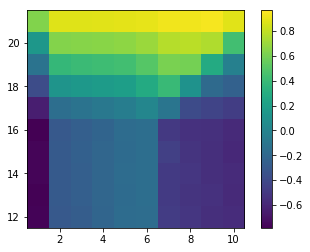

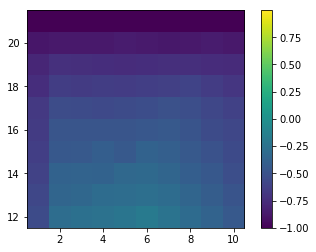

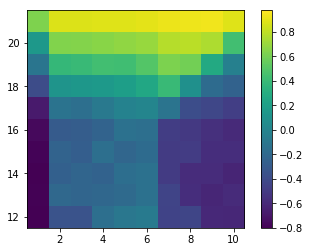

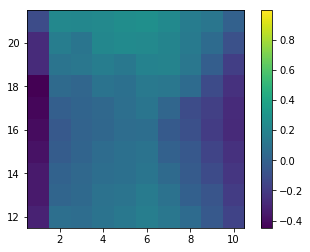

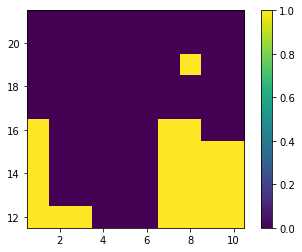

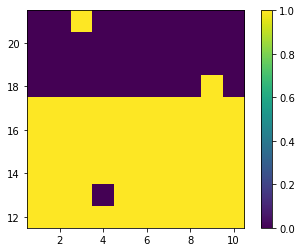

In [12]:
for i in range(2):
  for j in range(2):
    color_plot(q[:,:,i,j], 0.5, 10.5, 11.5, 21.5)
color_plot(policy[:,:,0], 0.5, 10.5, 11.5, 21.5)
color_plot(policy[:,:,1], 0.5, 10.5, 11.5, 21.5)

## Off-Policy Monte Carlo Prediction 
For policy evaluation

In [0]:
pi = (np.random.random((32, 11, 2)) < 0.5).astype(int)
b = np.random.random((32, 11, 2))
b = np.stack((b, 1-b), axis=3)
q = np.zeros((32, 11, 2, 2))
count = np.zeros((32, 11, 2, 2))

In [0]:
DISCOUNT = 1

for _ in range(1000000):
  hand, show, ace = env.reset()  
  done = False
  episode = []
#   Do the the episode following the policy
  while not done:
    state = (hand, show, int(ace))
    action = 0 if np.random.random() < b[state][0] else 1
    (hand, show, ace), reward, done, _ = env.step(action)
    
    episode.append((state, action, reward))
  
  g = 0
  w = 1
  while len(episode) > 0 and w != 0:
    state, action, reward = episode.pop()
    g = DISCOUNT * g + reward
    
    sa = state + tuple([action])
    
    count[sa] += w
    q[sa] += (w * (g - q[sa])) / count[sa]
    w *= pi[state]/b[sa]
    

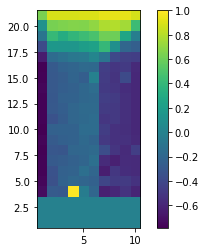

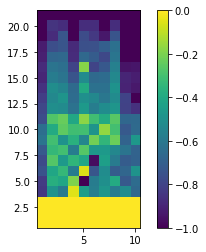

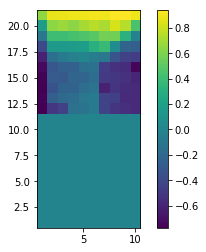

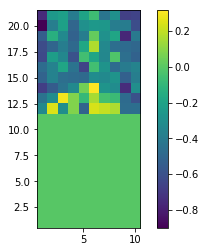

In [15]:
for i in range(2):
  for j in range(2):
    color_plot(q[:,:,i,j], 0.5, 10.5, 0.5, 21.5)

## Off Policy Monte Carlo Control

In [0]:
b = np.ones((32, 11, 2)) * 0.5
q = np.zeros((32, 11, 2, 2))
count = np.zeros((32, 11, 2, 2))
pi = np.argmax(q, axis=3)

DISCOUNT = 1

In [0]:
for _ in range(10000000):
  hand, show, ace = env.reset()
  
  done = False
  episode = []
  
#   Do the the episode following the policy b
  while not done:
    state = (hand, show, int(ace))
    action = 0 if np.random.random() < b[state] else 1
    (hand, show, ace), reward, done, _ = env.step(action)
    
    episode.append((state, action, reward))
  
  g = 0
  w = 1
  while len(episode) > 0:
    state, action, reward = episode.pop()
    g = DISCOUNT * g + reward
    
    sa = state + tuple([action])
    
    count[sa] += w
    q[sa] += (w * (g - q[sa])) / count[sa]
    pi[state] = np.argmax(q[state])
    if action != pi[state]:
      break
    
    w = w / b[state] if action == 0 else w / (1 - b[state])
    

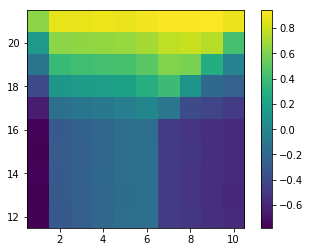

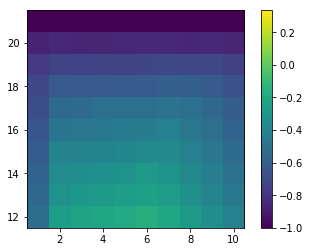

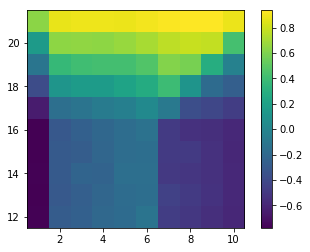

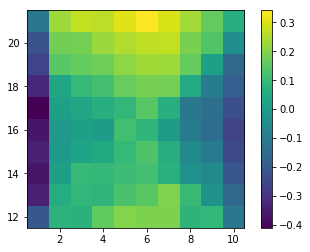

In [18]:
for i in range(2):
  for j in range(2):
    color_plot(q[:,:,i,j], 0.5, 10.5, 11.5, 21.5)